# Прогноз оттока клиентов фитнес-клуба

- Необходимо спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- Сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- Проанализировать основные признаки, наиболее сильно влияющие на отток;
- Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    - выделить целевые группы клиентов;
    - предложить меры по снижению оттока;
    - определить другие особенности взаимодействия с клиентами.

# EDA

In [37]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn import linear_model, ensemble, cluster, tree, metrics
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings('ignore')

# Options for pandas
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 300

df = pd.read_csv('/datasets/gym_churn.csv') 


In [38]:
df.head()
df.info()
df.describe()
df.duplicated().sum()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


0

- В данных нет пропущенных значений, нет явных дубликатов, все столбцы (кроме `Month_to_end_contract`) имеют правильный тип данных
- В среднем отток в текущем месяце - 26.5%
- Средний возраст 29 лет с с. к. о 3 года
- В среднем около 85% клиентов живут или работают около фитнес-центра
- Примерно половина клиентов - сотрудники компаний-партнеров клуба
- Пол также распределился равномерно
- Средняя частота посещений в неделю за все время по всем клиентам  около 1.88
- Средняя частота посещений в неделю за прошлый месяц по всем клиентам около 1.77

In [39]:
df['Month_to_end_contract'] = df['Month_to_end_contract'].astype('int')

In [40]:
df.groupby('Churn').mean().T

Churn,0,1
gender,0.510037,0.510839
Near_Location,0.873086,0.768143
Partner,0.534195,0.355325
Promo_friends,0.353522,0.183789
Phone,0.903709,0.902922
Contract_period,5.747193,1.728558
Group_visits,0.464103,0.268615
Age,29.976523,26.989632
Avg_additional_charges_total,158.445715,115.082899
Month_to_end_contract,5.283089,1.662582


Все средние показатели признаков выше для тех, кто не ушел

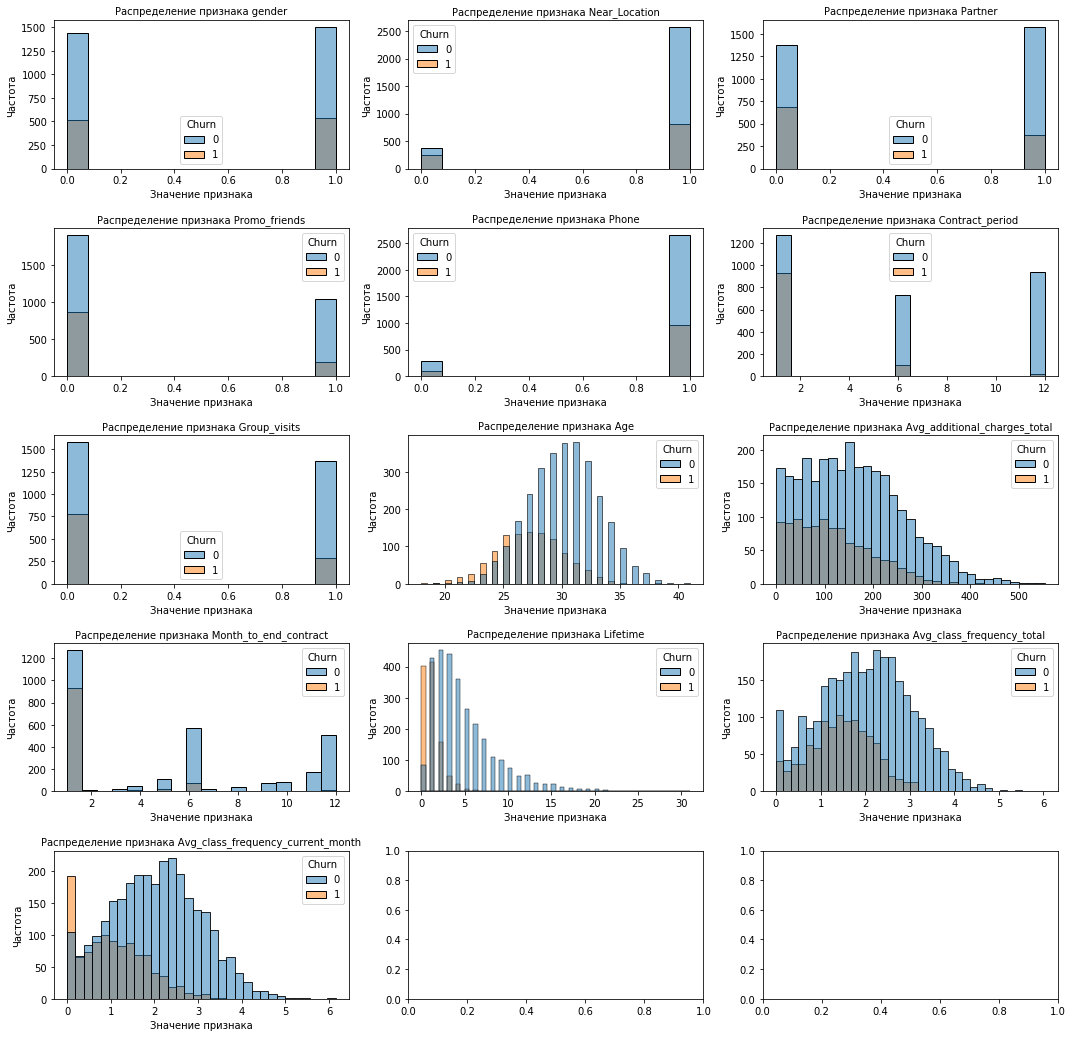

In [41]:
fig, axes = plt.subplots(5, 3, figsize = (18, 18))
axes = axes.ravel() 

cols = df.drop('Churn', axis=1).columns

for col, ax in zip(cols, axes):
    sns.histplot(data=df, x = col,  hue='Churn', ax=ax, palette='tab10')
    ax.set_title(f'Распределение признака {col}', fontsize = 10)
    ax.set_xlabel('Значение признака', fontsize = 10)
    ax.set_ylabel('Частота', fontsize = 10)
    
plt.subplots_adjust(wspace=0.2, hspace=0.4)    
plt.show();

- Соотношение тех, кто ушел и тех, кто остался одинаково для обоих полов
- Самый большой отток среди тех, у кого абонемент на 1 месяц, а самый маленький - среди тех, у кого на 12
- Возрастной признак нормально распределен для обеих категорий, но у ушедших среднее смещено на 3 года относительно оставшихся
- Почти у всех ушедших до окончания текущего абонемента оставался 1 месяц
- Большинство тех, кто ушли, сделали это либо сразу, либо в течение первого месяца с момента первого обращения в фитнес-центр 
- Очень много ушедших клиентов вообще не посетили фитнес-центр за предыдущий месяц, и почти у всех средняя частота не превышает 3

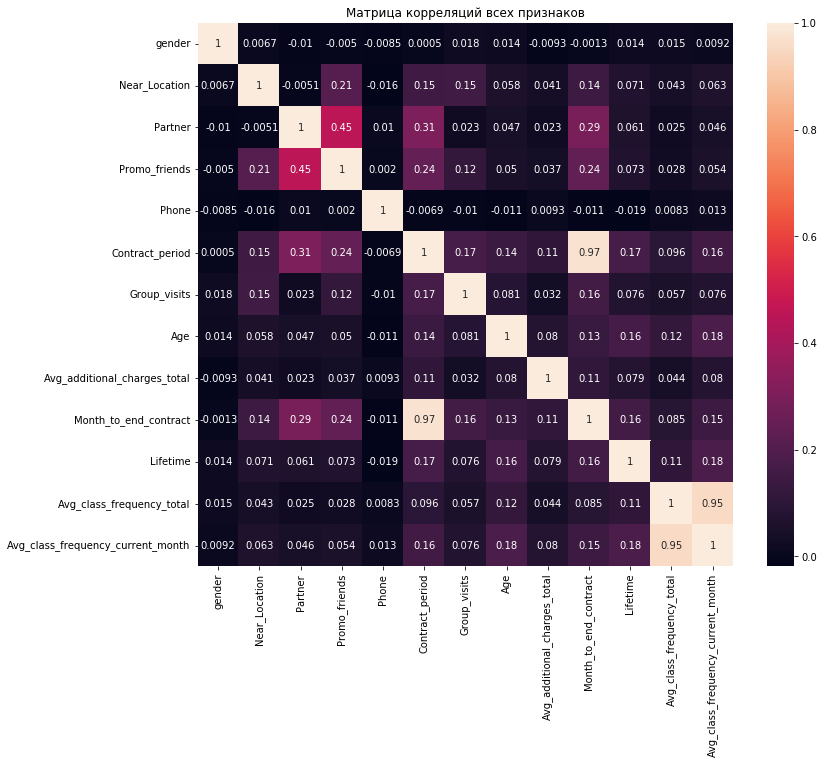

In [42]:
plt.figure(figsize = (12, 10))

sns.heatmap(df.drop('Churn', axis= 1).corr(), annot = True )

plt.title('Матрица корреляций всех признаков')
plt.show();

- Высокая корреляция наблюдается у длительности и у срока до окончания текущего действующего абонемента
- Также корреляция высокая у средней частоты посещений в неделю за все время и за предыдущий месяц с начала действия абонемента


# Модель прогнозирования оттока клиентов

Стоит убрать признаки `Month_to_end_contract` и `Avg_class_frequency_current_month`, так как они добавляют в модель мультиколлинеарность

In [43]:
X = df.drop(['Month_to_end_contract', 'Avg_class_frequency_current_month', 'Churn'], axis = 1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=0)

log_reg = linear_model.LogisticRegression(random_state=0)

log_reg.fit(X_train, y_train)

log_reg_pred = log_reg.predict(X_test)

rand_forest = ensemble.RandomForestClassifier(n_estimators = 100, random_state=0)

rand_forest.fit(X_train, y_train)

rand_f_pred = rand_forest.predict(X_test)



for i, j in zip([log_reg_pred, rand_f_pred], ['LogisticRegression:', 'RandomForestClassifier:']):
    print(f'{j} \naccuracy_score: {metrics.accuracy_score(y_test, i)}\n\
precision_score: {metrics.precision_score(y_test, i)}\n\
recall_score: {metrics.recall_score(y_test, i)}\n\
f1_score: {metrics.f1_score(y_test, i)}\n\
roc_auc_score: {metrics.roc_auc_score(y_test, i)}\n')



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

LogisticRegression: 
accuracy_score: 0.9025
precision_score: 0.8252427184466019
recall_score: 0.8018867924528302
f1_score: 0.8133971291866029
roc_auc_score: 0.870331151328456

RandomForestClassifier: 
accuracy_score: 0.89375
precision_score: 0.8067632850241546
recall_score: 0.7877358490566038
f1_score: 0.7971360381861575
roc_auc_score: 0.8598543190861251



Показатели логистической регрессии чуть лучше, чем у случайного леса

Теперь проведем поиск оптимальных параметров для модели

In [44]:
lr_params = {'C': np.arange(0.1, 3.1, 0.1)}

lr_grid = GridSearchCV(log_reg, lr_params, cv=5, n_jobs=-1)

lr_grid.fit(X_train, y_train)

lr_grid.best_params_

lr_pred = lr_grid.predict(X_test)



rf_params = {'n_estimators': range(100, 105), 'max_depth': range(3, 7)}

rf_grid = GridSearchCV(rand_forest, rf_params, cv=5, n_jobs=-1)

rf_grid.fit(X_train, y_train)

rf_grid.best_params_

rf_pred = rf_grid.predict(X_test)

for i, j in zip([lr_pred, rf_pred], ['LogisticRegression:', 'RandomForestClassifier:']):
    print(f'{j} \naccuracy_score: {metrics.accuracy_score(y_test, i)}\n\
precision_score: {metrics.precision_score(y_test, i)}\n\
recall_score: {metrics.recall_score(y_test, i)}\n\
f1_score: {metrics.f1_score(y_test, i)}\n\
roc_auc_score: {metrics.roc_auc_score(y_test, i)}\n')



GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=0, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

{'C': 2.5000000000000004}

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=0,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_de

{'max_depth': 5, 'n_estimators': 100}

LogisticRegression: 
accuracy_score: 0.9025
precision_score: 0.8130841121495327
recall_score: 0.8207547169811321
f1_score: 0.8169014084507042
roc_auc_score: 0.8763637530483892

RandomForestClassifier: 
accuracy_score: 0.9
precision_score: 0.8707865168539326
recall_score: 0.7311320754716981
f1_score: 0.7948717948717948
roc_auc_score: 0.8460082146065974



Значительно вырос precision_score у случайного леса, однако f1 и roc_auc практически не изменились

In [45]:
scores_log_reg =  cross_validate(log_reg, X, y, cv = 5, \
               scoring = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc'))

print('LogisticRegression:')
for i in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    print(i, scores_log_reg['test_'+i].mean())

    
scores_rand_forest =  cross_validate(rand_forest, X, y, cv = 5, \
               scoring = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc'))

print('\nRandomForestClassifier:')
for i in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    print(i, scores_rand_forest['test_'+i].mean())

LogisticRegression:
accuracy 0.8969996285150446
precision 0.8168116880528485
recall 0.7888475507130835
f1 0.8023776963695711
roc_auc 0.9543529392363114

RandomForestClassifier:
accuracy 0.8995030648485388
precision 0.8319519227990201
recall 0.7784967667641067
f1 0.8041616952415536
roc_auc 0.9503439956029653


При кросс-валидации можно заметить значительное увеличение показателя roc-auc для обеих моделей, остальные метрики остались примерно на том же уровне, либо снизились по сравнению с самым первым обучением

# Кластеризация клиентов

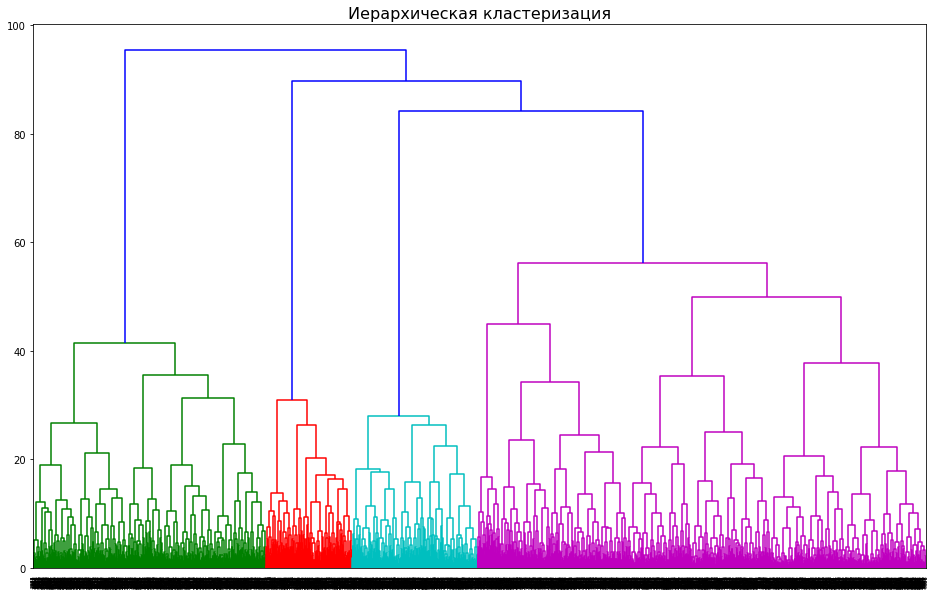

In [46]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method='ward')
plt.figure(figsize=(16, 10))
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация', fontsize=16)
plt.show();

In [47]:
km = cluster.KMeans(n_clusters = 5, random_state = 0)
labels = km.fit_predict(X_sc)
df['cluster_km'] = labels
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn,cluster_km
0,1,1,1,1,0,6,1,29,14.227470,5,3,0.020398,0.000000,0,4
1,0,1,0,0,1,12,1,31,113.202938,12,7,1.922936,1.910244,0,3
2,0,1,1,0,1,1,0,28,129.448479,1,2,1.859098,1.736502,0,2
3,0,1,1,1,1,12,1,33,62.669863,12,2,3.205633,3.357215,0,1
4,1,1,1,1,1,1,0,26,198.362265,1,3,1.113884,1.120078,0,1


In [48]:
df.groupby('cluster_km').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster_km,,,,,,,,,,,,,,
0,0.499109,0.000000,0.488414,0.076649,1.0,3.032086,0.235294,28.721925,137.540009,2.853832,3.060606,1.770413,1.606619,0.399287
1,0.488571,0.995238,0.955238,0.892381,1.0,7.660952,0.458095,29.543810,155.861428,6.988571,4.380952,1.978963,1.933736,0.120952
2,0.505300,1.000000,0.238516,0.059187,1.0,2.819788,0.000000,28.770318,143.383993,2.650177,3.343640,1.800647,1.645965,0.381625
3,0.544202,1.000000,0.250287,0.079219,1.0,4.528129,1.000000,29.536165,148.088897,4.165327,3.761194,1.941342,1.845911,0.200918
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,1.723967,0.266839


- У клиентов из 1 кластера самые лучшие показатели почти по всем признакам, также у них самый низкий процент оттока
- Еще низкий процент оттока у клиентов из 3 кластера
- Клиенты из 0 кластера не находятся рядом с фитнес-центром
- Клиенты из 4 кластера не оставляли свой номер телефона
- У клиентов из 0 и 2 кластера самый высокий процент оттока, они реже других посещали фитнес-центр, им осталось меньше 3 месяцев до окончания абонемента

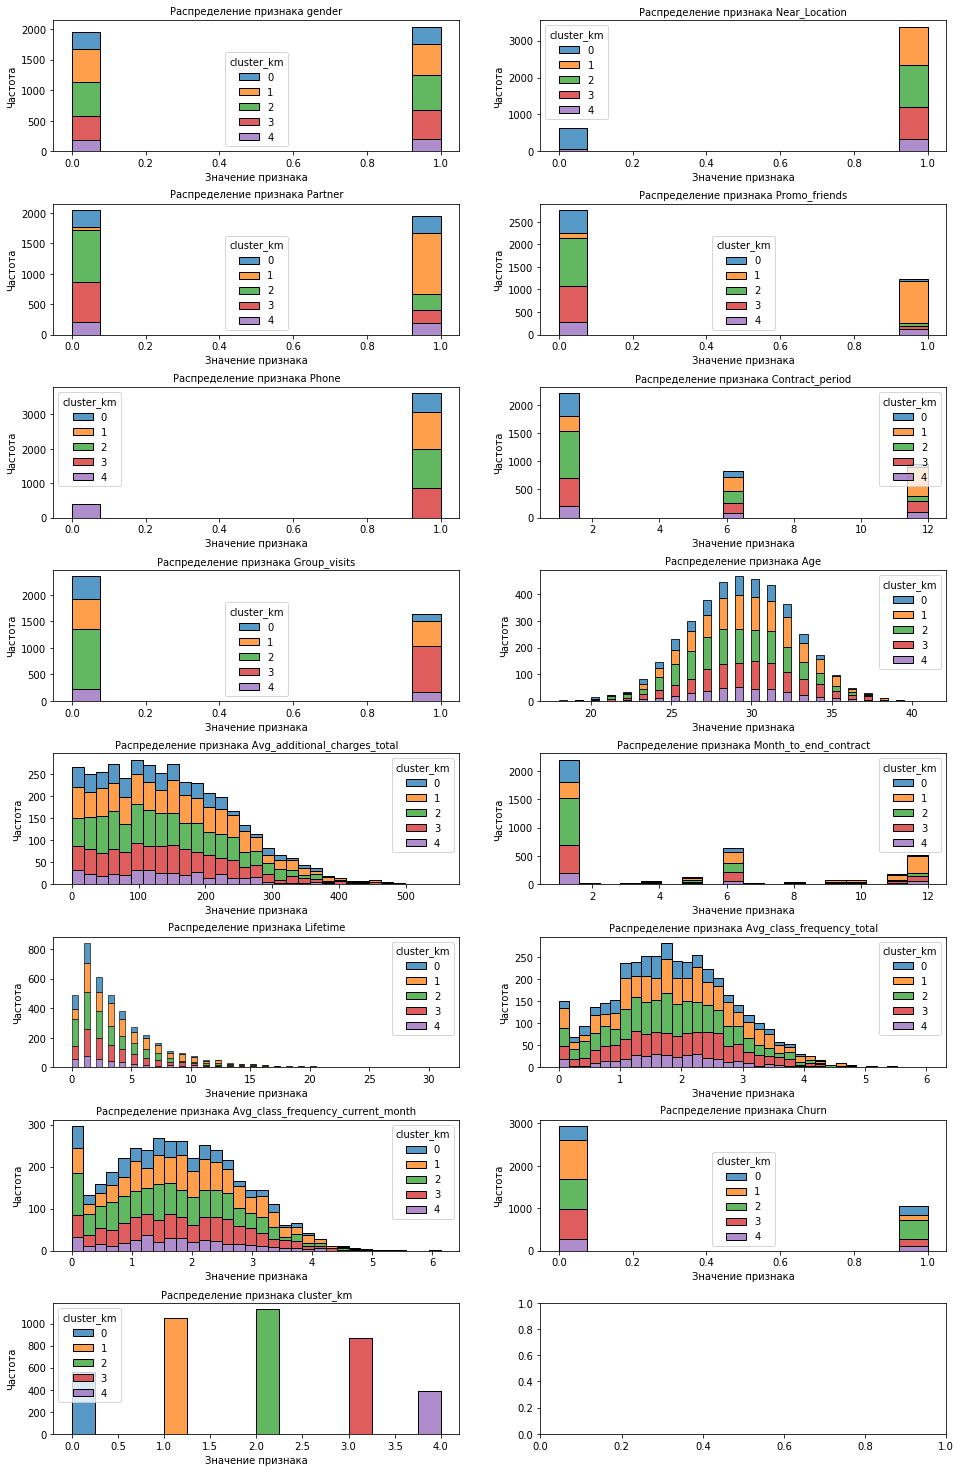

In [49]:
fig, axes = plt.subplots(8, 2, figsize = (16, 26))
axes = axes.ravel() 

for col, ax in zip(df, axes):
    sns.histplot(data=df, x = col,  hue='cluster_km', ax=ax, palette="tab10",\
                 stat="count", multiple="stack")
    ax.set_title(f'Распределение признака {col}', fontsize = 10)
    ax.set_xlabel('Значение признака', fontsize = 10)
    ax.set_ylabel('Частота', fontsize = 10)
    
plt.subplots_adjust(wspace=0.2, hspace=0.4)    
plt.show();

Так как самый высокий отток клиентов из 0 и 2 кластера, то стоит искать закономерности именно в них
- Из кластера 0 никто не работает и не живет рядом с клубом
- Кластер 2 - самый многочисленный
- Клиенты из этих кластера почти не использовали промо-коды от знакомых при оплате первого абонемента
- Все указывали свой телефон
- Никто из 2 кластера не посещал групповые занятия
- Почти у всех из кластеров действующий абонемент на 1 месяц, у некоторых на 6
- Большинству из этих кластеров осталось около 1 месяца до конца абонемента, некоторым - 6
- Очень многие из этих кластеров ни разу не сходили в фитнес центр, у остальных частота за прошлый месяц и вообще не превышает 4 раз



In [50]:
df.groupby(['cluster_km'])['Churn'].mean() * 100

cluster_km
0    39.928699
1    12.095238
2    38.162544
3    20.091848
4    26.683938
Name: Churn, dtype: float64

#  Выводы и рекомендации

Наиболее вероятен отток клиентов из 0 и 2 кластера. Отличительные особенности клиентов этих кластеров:
- Не пришли по промо-коду от знакомых
- Купили абонемент на 1 месяц
- Ни разу не сходили в клуб за время действия абонемента, либо ходили не чаще 4 раз в неделю в среднем

Тот факт, что длительность действия абонемента равна сроку до его окончания, говорит о том, что данные об оттоке клиента записаны в том же месяце, когда он купил абонемент. Т. е. человек купил абонемент на месяц и ни разу за этот месяц не пришел в клуб, после чего перестал быть клиентом

In [51]:
df[(df['Contract_period'] == 1) & (df['Month_to_end_contract'] == 1) \
       & (df['Churn'] == 1)]['cluster_km'].value_counts()

2    388
0    206
3    156
1     95
4     89
Name: cluster_km, dtype: int64

Таких клиентов почти четверть

По всей видимости целевыми являются клиенты из 1 и 3 кластера: 
- у них самые низкие показатели оттока
- в среднем они ходят в клуб чаще остальных
- также суммарная выручка от других услуг фитнес-центра от этих клиентов наибольшая

Про 1 кластер еще можно отметить: 
- почти все пришли по промо-коду
- многие в нем являются сотрудниками компаний-партнеров клуба, т.е покупают абонемент со скидкой
- большинство покупают абонемент на 12 месяцев, иногда на 6, причем до конца действия абонемента у них также остается 6-12 месяцев



Таким образом для снижения потенциального оттока и удержания клиентов можно: 
- строить больше партнерских отношений с компаниями, чтобы их сотрудники приходили в клуб и покупали лучшие абонементы, а также тратили деньги на другие услуги фитнес-центра
- желательно искать эти компании поблизости, так как удаленность влияет на то, будет клиент ходить или нет
- также стоит продолжать раздавать промокоды, так как много целевых клиентов приходят благодаря ним
- важно брать номер телефона и напоминать о всевозможных бонусах и акциях
- также важно, чтобы клиент купил абонемент с наибольшей длительностью, в таком случае ниже вероятность, что он быстро уйдет